In [1]:
import sys
sys.path.append('/proj/leousers/users/speech/syk2145/scripts')

In [ ]:
!conda activate nrse

## validate audio files

In [ ]:
from utils.audio.preprocess_audio_files import preprocess_audio_files
valid_files, invalied_filed = preprocess_audio_files("/proj/speech/users/syk2145/data/samples/Audioset") 

Validating audio files: 100%|██████████| 3911/3911 [00:03<00:00, 1170.14it/s]

Found 3911 valid files and 0 invalid files


In [ ]:
valid_files, invalied_filed = preprocess_audio_files("/proj/speech/projects/noise_robustness/MSP-PODCAST-Publish-1.11/Audios") 

Validating audio files: 100%|██████████| 151654/151654 [24:13<00:00, 104.32it/s]

Found 151654 valid files and 0 invalid files


In [4]:
valid_files, invalied_filed = preprocess_audio_files("/proj/speech/users/syk2145/data/Audios_en_sgmse/clean") 

Validating audio files: 100%|██████████| 151654/151654 [1:03:58<00:00, 39.51it/s] 

Found 151654 valid files and 0 invalid files


## process label

In [4]:
!python labels/processed/process_csv_label.py --input /proj/speech/users/syk2145/data/labels/MSP-Podcast/labels_consensus.csv --output labels/processed/labels_consensus_processed.csv

Total rows in input file: 149307
Found 29923 rows with 'X' and 3310 rows with 'O' in EmoClass
Filtered out 33233 rows
Saved 116074 rows to labels/processed/labels_consensus_processed.csv


In [11]:
# process text label to compatible with baseline model inference
!python labels/processed/process_txt_label.py --input labels/msp1_11-test2-clean-noisy.txt --output labels/processed/msp1_11-test2-clean-noisy_processed.txt

Processing complete.
Kept 34233 valid lines.
Filtered out 10212 lines with X or O labels.
Results saved to labels/processed/msp1_11-test2-clean-noisy_processed.txt


In [1]:
!python labels/processed/process_txt_label.py --input labels/msp1_11-train-clean-noisy.txt --output labels/processed/msp1_11-train-clean-noisy_processed.txt

Processing complete.
Kept 130410 valid lines.
Filtered out 37650 lines with X or O labels.
Results saved to labels/processed/msp1_11-train-clean-noisy_processed.txt


## test 

### encoder

In [10]:
!python src/models/encoder.py

Embeddings shape: torch.Size([2, 768])
Embeddings are numerically stable.
No infinite values in embeddings.


### config

In [36]:
from config import load_config 
config = load_config("/proj/speech/users/syk2145/nrse/config/dev.yaml")
epoch = 3
print(config['logging']['metric_logging_interval'], config['logging']['visualization_interval'])

print((epoch + 1) % config['logging']['metric_logging_interval'] == 1)
print((epoch + 1) % config['logging']['visualization_interval'] == 1)

1 1
False
False


### evaluation

In [ ]:
from src.models.byol import BYOLSpeechModel
from config import load_config 
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = load_config("/proj/speech/users/syk2145/nrse/config/dev.yaml")
checkpoint = torch.load("/proj/speech/users/syk2145/nrse/checkpoints/best_model.pt", map_location=device)
model = BYOLSpeechModel(config).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
from transformers import AutoFeatureExtractor
from src.models.encoder import WavLMEncoder
from data.noisy_speech_dataset import create_dataloader

feature_extractor = AutoFeatureExtractor.from_pretrained(config['model']['name'])
dataloader = create_dataloader(config, feature_extractor)

Found 7582 clean files and 3911 noise files.


: 

In [ ]:
from evaluate import evaluate_embedding_similarity
similarities = evaluate_embedding_similarity(model, dataloader, device)
similarities

{0: 0.8184624527181897,
 5: 0.9240977281615848,
 10: 0.9537629164182223,
 15: 0.975070940123664,
 20: 0.9920731782913208}

In [ ]:
import importlib
import evaluate_byol
importlib.reload(evaluate_byol)

evaluate_byol.visualize_embeddings(model, dataloader, device, "/proj/speech/users/syk2145/nrse/output")

Visualization saved to /proj/speech/users/syk2145/nrse/output/tsne_embeddings.png


### augrmentation

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchaudio
import IPython.display as ipd
from tqdm.notebook import tqdm

# Assuming add_noise_to_speech is in a module you can import
from src.data.augment import add_noise_to_speech

def test_add_noise_to_speech(clean_audio_path, noise_audio_path, snr_values=[-10, -5, 0, 5, 10, 15, 20]):
    """
    Test the add_noise_to_speech function with different SNR values
    and visualize/play the results.
    
    Args:
        clean_audio_path: Path to clean speech file
        noise_audio_path: Path to noise file
        snr_values: List of SNR values to test
    """
    # Load audio files
    clean_speech, sr = torchaudio.load(clean_audio_path)
    noise, noise_sr = torchaudio.load(noise_audio_path)
    
    # Resample noise if needed
    if noise_sr != sr:
        noise = torchaudio.functional.resample(noise, noise_sr, sr)
    
    # Make sure both are mono
    if clean_speech.shape[0] > 1:
        clean_speech = torch.mean(clean_speech, dim=0, keepdim=True)
    if noise.shape[0] > 1:
        noise = torch.mean(noise, dim=0, keepdim=True)
    
    # Trim or pad noise to match speech length
    if noise.shape[1] > clean_speech.shape[1]:
        noise = noise[:, :clean_speech.shape[1]]
    elif noise.shape[1] < clean_speech.shape[1]:
        padding = clean_speech.shape[1] - noise.shape[1]
        noise = torch.nn.functional.pad(noise, (0, padding))
    
    # Normalize audio
    clean_speech = clean_speech / (torch.max(torch.abs(clean_speech)) + 1e-8)
    noise = noise / (torch.max(torch.abs(noise)) + 1e-8)
    
    # Create a figure for visualization
    plt.figure(figsize=(15, 10))
    
    # Plot original clean speech
    plt.subplot(len(snr_values) + 1, 1, 1)
    plt.plot(clean_speech[0].numpy())
    plt.title(f"Clean Speech")
    plt.ylim(-1.1, 1.1)
    
    # Test with different SNR values
    noisy_speeches = []
    
    for i, snr in enumerate(snr_values):
        # Add noise to speech
        noisy_speech = add_noise_to_speech(clean_speech, noise, snr)
        noisy_speeches.append(noisy_speech)
        
        # Calculate actual SNR achieved
        speech_power = torch.mean(clean_speech ** 2).item()
        noise_component = noisy_speech - clean_speech
        noise_power = torch.mean(noise_component ** 2).item()
        actual_snr = 10 * np.log10(speech_power / noise_power) if noise_power > 0 else float('inf')
        
        # Plot noisy speech
        plt.subplot(len(snr_values) + 1, 1, i + 2)
        plt.plot(noisy_speech[0].numpy())
        plt.title(f"Noisy Speech (Target SNR: {snr} dB, Actual SNR: {actual_snr:.2f} dB)")
        plt.ylim(-1.1, 1.1)
    
    plt.tight_layout()
    plt.show()
    
    # Play audio samples
    print("Clean Speech:")
    display(ipd.Audio(clean_speech[0].numpy(), rate=sr))
    
    for i, snr in enumerate(snr_values):
        print(f"Noisy Speech (SNR: {snr} dB):")
        display(ipd.Audio(noisy_speeches[i][0].numpy(), rate=sr))

# Example usage
# test_add_noise_to_speech('path/to/clean_speech.wav', 'path/to/noise.wav')

In [2]:
from utils.os.get_file_sample import get_file_sample
speech_list = get_file_sample("/proj/speech/users/syk2145/data/samples/Audios")
noisy_list = get_file_sample("/proj/speech/users/syk2145/data/samples/Audioset")

Found 7582 files in /proj/speech/users/syk2145/data/samples/Audios
Selected 379 files (5%)
Found 3911 files in /proj/speech/users/syk2145/data/samples/Audioset
Selected 195 files (5%)


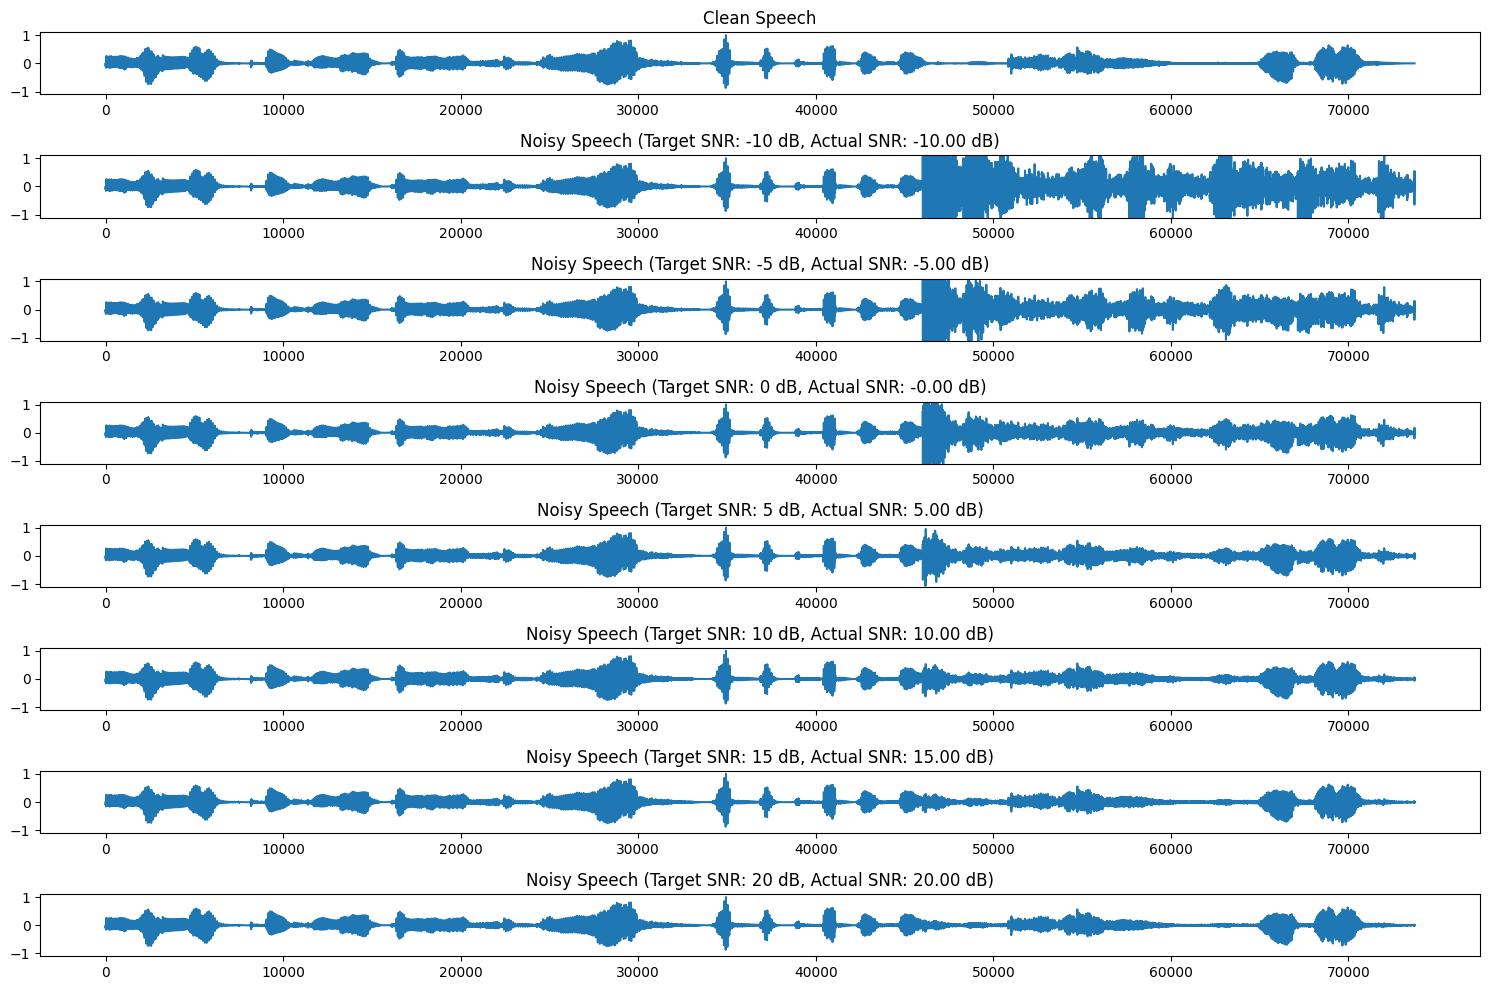

Clean Speech:


Noisy Speech (SNR: -10 dB):


Noisy Speech (SNR: -5 dB):


Noisy Speech (SNR: 0 dB):


Noisy Speech (SNR: 5 dB):


Noisy Speech (SNR: 10 dB):


Noisy Speech (SNR: 15 dB):


Noisy Speech (SNR: 20 dB):


In [11]:
test_add_noise_to_speech(speech_list[1], noisy_list[2], snr_values=[-10, -5, 0, 5, 10, 15, 20])

## benchmarking metric

### WavLM baseline

In [ ]:
result_path = "/proj/speech/users/syk2145/nrse/inference_results/baseline/AutoModel/textfile/test2-clean"
!python src/metrics/categorical_metrics.py \
  --predictions {result_path}/emotion_predictions.csv \
  --ground_truth /proj/speech/projects/noise_robustness/MSP-PODCAST-Publish-1.11/Labels/labels_consensus.csv \
  --output_dir {result_path}/metrics \
  --split Test2

Loading predictions from /proj/speech/users/syk2145/nrse/inference_results/baseline/AutoModel/textfile/test2-clean/emotion_predictions.csv
Loading ground truth from /proj/speech/projects/noise_robustness/MSP-PODCAST-Publish-1.11/Labels/labels_consensus.csv
Filtered ground truth to 'Test2' split: 14815 samples (from 149307)
Merging predictions with ground truth
Found 14815 matched samples out of 14815 predictions
Total samples before filtering: 14815
Total samples after filtering out X and O: 11411
Accuracy: 0.3899
Macro F1: 0.2332
Weighted F1: 0.4417
Classification report saved to /proj/speech/users/syk2145/nrse/inference_results/baseline/AutoModel/textfile/test2-clean/metrics/Test2_classification_report.csv
Confusion matrix saved to /proj/speech/users/syk2145/nrse/inference_results/baseline/AutoModel/textfile/test2-clean/metrics/Test2_confusion_matrix.png
F1 score plot saved to /proj/speech/users/syk2145/nrse/inference_results/baseline/AutoModel/textfile/test2-clean/metrics/Test2_f1_b

In [4]:
result_path = "/proj/speech/users/syk2145/nrse/inference_results/baseline/AutoModel/textfile/dev-clean"
!python src/metrics/categorical_metrics.py \
  --predictions {result_path}/emotion_predictions.csv \
  --ground_truth /proj/speech/projects/noise_robustness/MSP-PODCAST-Publish-1.11/Labels/labels_consensus.csv \
  --output_dir {result_path}/metrics \
  --split Development

Loading predictions from /proj/speech/users/syk2145/nrse/inference_results/baseline/AutoModel/textfile/dev-clean/emotion_predictions.csv
Loading ground truth from /proj/speech/projects/noise_robustness/MSP-PODCAST-Publish-1.11/Labels/labels_consensus.csv
Filtered ground truth to 'Development' split: 19815 samples (from 149307)
Merging predictions with ground truth
Found 19815 matched samples out of 19815 predictions
Total samples before filtering: 19815
Total samples after filtering out X and O: 15341
Accuracy: 0.4090
Macro F1: 0.3071
Weighted F1: 0.4176
Classification report saved to /proj/speech/users/syk2145/nrse/inference_results/baseline/AutoModel/textfile/dev-clean/metrics/Development_classification_report.csv
Confusion matrix saved to /proj/speech/users/syk2145/nrse/inference_results/baseline/AutoModel/textfile/dev-clean/metrics/Development_confusion_matrix.png
F1 score plot saved to /proj/speech/users/syk2145/nrse/inference_results/baseline/AutoModel/textfile/dev-clean/metrics/

In [5]:
result_path = "/proj/speech/users/syk2145/nrse/inference_results/baseline/AutoModel/textfile/test2-snr4"
!python src/metrics/categorical_metrics.py \
  --predictions {result_path}/emotion_predictions.csv \
  --ground_truth /proj/speech/projects/noise_robustness/MSP-PODCAST-Publish-1.11/Labels/labels_consensus.csv \
  --output_dir {result_path}/metrics \
  --split Test2

Loading predictions from /proj/speech/users/syk2145/nrse/inference_results/baseline/AutoModel/textfile/test2-snr4/emotion_predictions.csv
Loading ground truth from /proj/speech/projects/noise_robustness/MSP-PODCAST-Publish-1.11/Labels/labels_consensus.csv
Filtered ground truth to 'Test2' split: 14815 samples (from 149307)
Merging predictions with ground truth
Found 14779 matched samples out of 14779 predictions
Total samples before filtering: 14779
Total samples after filtering out X and O: 11386
Accuracy: 0.4025
Macro F1: 0.2234
Weighted F1: 0.4490
Classification report saved to /proj/speech/users/syk2145/nrse/inference_results/baseline/AutoModel/textfile/test2-snr4/metrics/Test2_classification_report.csv
Confusion matrix saved to /proj/speech/users/syk2145/nrse/inference_results/baseline/AutoModel/textfile/test2-snr4/metrics/Test2_confusion_matrix.png
F1 score plot saved to /proj/speech/users/syk2145/nrse/inference_results/baseline/AutoModel/textfile/test2-snr4/metrics/Test2_f1_by_cl

In [6]:
result_path = "/proj/speech/users/syk2145/nrse/inference_results/baseline/AutoModel/textfile/test2-snr8"
!python src/metrics/categorical_metrics.py \
  --predictions {result_path}/emotion_predictions.csv \
  --ground_truth /proj/speech/projects/noise_robustness/MSP-PODCAST-Publish-1.11/Labels/labels_consensus.csv \
  --output_dir {result_path}/metrics \
  --split Test2

Loading predictions from /proj/speech/users/syk2145/nrse/inference_results/baseline/AutoModel/textfile/test2-snr8/emotion_predictions.csv
Loading ground truth from /proj/speech/projects/noise_robustness/MSP-PODCAST-Publish-1.11/Labels/labels_consensus.csv
Filtered ground truth to 'Test2' split: 14815 samples (from 149307)
Merging predictions with ground truth
Found 14779 matched samples out of 14779 predictions
Total samples before filtering: 14779
Total samples after filtering out X and O: 11384
Accuracy: 0.4144
Macro F1: 0.2353
Weighted F1: 0.4626
Classification report saved to /proj/speech/users/syk2145/nrse/inference_results/baseline/AutoModel/textfile/test2-snr8/metrics/Test2_classification_report.csv
Confusion matrix saved to /proj/speech/users/syk2145/nrse/inference_results/baseline/AutoModel/textfile/test2-snr8/metrics/Test2_confusion_matrix.png
F1 score plot saved to /proj/speech/users/syk2145/nrse/inference_results/baseline/AutoModel/textfile/test2-snr8/metrics/Test2_f1_by_cl

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

result_path = "/proj/speech/users/syk2145/nrse/inference_results/baseline/AutoModel/textfile/test2-all"
!python src/metrics/categorical_metrics.py \
  --predictions {result_path}/emotion_predictions.csv \
  --ground_truth /proj/speech/projects/noise_robustness/MSP-PODCAST-Publish-1.11/Labels/labels_consensus.csv \
  --output_dir {result_path}/metrics \
  --split Test2

Loading predictions from /proj/speech/users/syk2145/nrse/inference_results/baseline/AutoModel/textfile/test2-all/emotion_predictions.csv
Loading ground truth from /proj/speech/projects/noise_robustness/MSP-PODCAST-Publish-1.11/Labels/labels_consensus.csv
Filtered ground truth to 'Test2' split: 14815 samples (from 149307)
Merging predictions with ground truth
Found 44373 matched samples out of 44373 predictions
Total samples before filtering: 44373
Total samples after filtering out X and O: 34181
Accuracy: 0.4024
Macro F1: 0.2309
Weighted F1: 0.4515
Classification report saved to /proj/speech/users/syk2145/nrse/inference_results/baseline/AutoModel/textfile/test2-all/metrics/Test2_classification_report.csv
Confusion matrix saved to /proj/speech/users/syk2145/nrse/inference_results/baseline/AutoModel/textfile/test2-all/metrics/Test2_confusion_matrix.png
F1 score plot saved to /proj/speech/users/syk2145/nrse/inference_results/baseline/AutoModel/textfile/test2-all/metrics/Test2_f1_by_class.

### NRSER

In [4]:
!python inference_results/nrser/reformat_result_csv.py 

/proj/leousers/users/speech/syk2145/nrse/inference_results/nrser/reformat_result_csv.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, pd.DataFrame([new_row])], ignore_index=True)
Conversion complete. Output saved to inference_results/nrser/converted_nrser_per_file_results_all.csv


In [ ]:
result_path = "/proj/speech/users/syk2145/nrse/inference_results/hubert-based/clean"
!python src/metrics/categorical_metrics.py \
  --predictions {result_path}/emotion_predictions.csv \
  --ground_truth /proj/speech/projects/noise_robustness/MSP-PODCAST-Publish-1.11/Labels/labels_consensus.csv \
  --output_dir {result_path}/metrics \

Loading predictions from /proj/speech/users/syk2145/nrse/inference_results/hubert-based/clean/emotion_predictions.csv
Loading ground truth from /proj/speech/projects/noise_robustness/MSP-PODCAST-Publish-1.11/Labels/labels_consensus.csv
Merging predictions with ground truth
Found 44445 matched samples out of 44445 predictions
Total samples before filtering: 44445
Total samples after filtering out X and O: 34233
Filtered out 2955 predictions that were not valid emotion labels.
Accuracy: 0.4729
Macro F1: 0.1255
Weighted F1: 0.4255
/home/syk2145/miniconda3/envs/nrse/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/syk2145/miniconda3/envs/nrse/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarni

In [4]:
result_path = "/proj/speech/users/syk2145/nrse/inference_results/hubert-based/nrser"
!python src/metrics/categorical_metrics.py \
  --predictions {result_path}/emotion_predictions.csv \
  --ground_truth /proj/speech/projects/noise_robustness/MSP-PODCAST-Publish-1.11/Labels/labels_consensus.csv \
  --output_dir {result_path}/metrics

Loading predictions from /proj/speech/users/syk2145/nrse/inference_results/hubert-based/nrser/emotion_predictions.csv
Loading ground truth from /proj/speech/projects/noise_robustness/MSP-PODCAST-Publish-1.11/Labels/labels_consensus.csv
Merging predictions with ground truth
Found 44445 matched samples out of 44445 predictions
Total samples before filtering: 44445
Total samples after filtering out X and O: 34233
Filtered out 5147 predictions that were not valid emotion labels.
Accuracy: 0.5500
Macro F1: 0.1392
Weighted F1: 0.4783
/home/syk2145/miniconda3/envs/nrse/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/syk2145/miniconda3/envs/nrse/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarni

# Training

In [ ]:
!python train_byol.py --config config/dev_wavlm-large.yaml --device cuda:1

```sh
 └─ [2025-04-26 00:01:34] $ python train_byol.py --config config/default_wavlm-large_byol.yaml
Found 151654 clean files and 19564 noise files.
Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3581/3581 [1:29:18<00:00,  1.50s/it]
Evaluating similarity: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 632/632 [08:06<00:00,  1.30it/s]
Calculating validation loss: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 632/632 [08:57<00:00,  1.18it/s]
Epoch 1/100 - Train Loss: 0.7087, Val Loss: 0.3303, Val Avg Similarity: 0.9763
Saved best model checkpoint with validation loss: 0.3303
Saved best model checkpoint with validation similarity: 0.9763
Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3581/3581 [1:29:14<00:00,  1.50s/it]
Evaluating similarity: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 632/632 [08:08<00:00,  1.29it/s]
Calculating validation loss: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 632/632 [08:59<00:00,  1.17it/s]
Epoch 2/100 - Train Loss: 0.3586, Val Loss: 0.3100, Val Avg Similarity: 0.9886
Visualization saved to outputs/byol/wavlm_large-snr2_20-ema_997/tsne_embeddings_epoch_2.png
Saved best model checkpoint with validation loss: 0.3100
Saved best model checkpoint with validation similarity: 0.9886
Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3581/3581 [1:29:24<00:00,  1.50s/it]
Evaluating similarity: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 632/632 [08:14<00:00,  1.28it/s]
Calculating validation loss: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 632/632 [09:08<00:00,  1.15it/s]
Epoch 3/100 - Train Loss: 0.3298, Val Loss: 0.2901, Val Avg Similarity: 0.9925
Saved best model checkpoint with validation loss: 0.2901
Saved best model checkpoint with validation similarity: 0.9925
Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3581/3581 [1:29:20<00:00,  1.50s/it]
Evaluating similarity: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 632/632 [08:03<00:00,  1.31it/s]
Calculating validation loss: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 632/632 [09:02<00:00,  1.16it/s]
Epoch 4/100 - Train Loss: 0.3254, Val Loss: 0.2439, Val Avg Similarity: 0.9933
Visualization saved to outputs/byol/wavlm_large-snr2_20-ema_997/tsne_embeddings_epoch_4.png
Saved best model checkpoint with validation loss: 0.2439
Saved best model checkpoint with validation similarity: 0.9933
Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3581/3581 [1:29:13<00:00,  1.49s/it]
Evaluating similarity: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 632/632 [08:11<00:00,  1.29it/s]
Calculating validation loss: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 632/632 [09:06<00:00,  1.16it/s]
Epoch 5/100 - Train Loss: 0.3289, Val Loss: 0.2552, Val Avg Similarity: 0.9934
Saved best model checkpoint with validation similarity: 0.9934
Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3581/3581 [1:30:45<00:00,  1.52s/it]
Evaluating similarity: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 632/632 [08:05<00:00,  1.30it/s]
Calculating validation loss: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 632/632 [08:57<00:00,  1.18it/s]
Epoch 6/100 - Train Loss: 0.3381, Val Loss: 0.2538, Val Avg Similarity: 0.9929
Visualization saved to outputs/byol/wavlm_large-snr2_20-ema_997/tsne_embeddings_epoch_6.png
Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3581/3581 [1:29:22<00:00,  1.50s/it]
Evaluating similarity: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 632/632 [08:04<00:00,  1.30it/s]
Calculating validation loss: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 632/632 [08:57<00:00,  1.18it/s]
Epoch 7/100 - Train Loss: 0.3365, Val Loss: 0.2532, Val Avg Similarity: 0.9934
Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3581/3581 [1:29:21<00:00,  1.50s/it]
Evaluating similarity: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 632/632 [08:04<00:00,  1.30it/s]
Calculating validation loss: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 632/632 [08:55<00:00,  1.18it/s]
Epoch 8/100 - Train Loss: 0.3387, Val Loss: 0.2561, Val Avg Similarity: 0.9931
Early stopping triggered after epoch 8
Training complete!
```

In [ ]:
# !python train_emotion.py --config config/dev_wavlm-large.yaml --task categorical
!bash baseline/run_train_e2e.sh

 ```sh
 └─ [2025-05-03 00:13:55] $ bash baseline/run_train_e2e.sh
{'Angry': 1.7941176470588236, 'Sad': 1.471539573545356, 'Happy': 0.4812090054954795, 'Surprise': 2.7826755509994876, 'Fear': 7.124671916010499, 'Disgust': 5.684816753926701, 'Contempt': 3.3016420028380296, 'Neutral': 0.26979972501532296}
tensor([1.7941, 1.4715, 0.4812, 2.7827, 7.1247, 5.6848, 3.3016, 0.2698],
       device='cuda:0')
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130296/130296 [03:33<00:00, 611.20it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39586/39586 [01:00<00:00, 656.51it/s]
/home/syk2145/miniconda3/envs/baseline/lib/python3.9/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Training with unfrozen SSL encoder
Loading pre-trained  microsoft/wavlm-large  model...
AttentiveStatisticsPooling(
  (sap_linear): Linear(in_features=1024, out_features=1024, bias=True)
)
Epoch:  0
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16287/16287 [2:23:44<00:00,  1.89it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39586/39586 [14:49<00:00, 44.52it/s]
train_loss : 1.9095 / dev_loss : 0.6539 /
Save 0
Loss 0.6539
Epoch:  1
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16287/16287 [2:24:34<00:00,  1.88it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39586/39586 [14:42<00:00, 44.86it/s]
train_loss : 1.8123 / dev_loss : 0.3661 /
Save 1
Loss 0.3661
Epoch:  2
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16287/16287 [2:23:32<00:00,  1.89it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39586/39586 [14:36<00:00, 45.18it/s]
train_loss : 1.7623 / dev_loss : 0.1741 /
Save 2
Loss 0.1741
Epoch:  3
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16287/16287 [2:23:05<00:00,  1.90it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39586/39586 [14:35<00:00, 45.20it/s]
train_loss : 1.7042 / dev_loss : 0.1068 /
Save 3
Loss 0.1068
Epoch:  4
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16287/16287 [2:24:04<00:00,  1.88it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39586/39586 [14:58<00:00, 44.07it/s]
train_loss : 1.6675 / dev_loss : 0.0483 /
Save 4
Loss 0.0483
Epoch:  5
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16287/16287 [2:24:12<00:00,  1.88it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39586/39586 [14:57<00:00, 44.09it/s]
train_loss : 1.6304 / dev_loss : 0.0295 /
Save 5
Loss 0.0295
Epoch:  6
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16287/16287 [2:24:10<00:00,  1.88it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39586/39586 [15:05<00:00, 43.71it/s]
train_loss : 1.6013 / dev_loss : 0.0197 /
Save 6
Loss 0.0197
Epoch:  7
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16287/16287 [2:23:04<00:00,  1.90it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39586/39586 [15:02<00:00, 43.87it/s]
train_loss : 1.5769 / dev_loss : 0.03 /
Epoch:  8
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16287/16287 [2:23:30<00:00,  1.89it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39586/39586 [15:03<00:00, 43.82it/s]
train_loss : 1.5445 / dev_loss : 0.0155 /
Save 8
Loss 0.0155
Epoch:  9
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16287/16287 [2:21:30<00:00,  1.92it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39586/39586 [15:01<00:00, 43.89it/s]
train_loss : 1.5166 / dev_loss : 0.0208 /
```

# eval

In [9]:
!python baseline/convert_prediction_to_csv.py --input /proj/speech/users/syk2145/baseline/MSP-Podcast_Challenge/baseline/model/nrse_best_sim/2_best_sim/results/inference_results.csv --output inference_results/baseline/fine_tuned/emotion_predictions.csv

Converted file saved to inference_results/baseline/fine_tuned/emotion_predictions.csv


In [10]:
result_path = "inference_results/baseline/fine_tuned"
!python src/metrics/categorical_metrics.py \
  --predictions {result_path}/emotion_predictions.csv \
  --ground_truth /proj/speech/projects/noise_robustness/MSP-PODCAST-Publish-1.11/Labels/labels_consensus.csv \
  --output_dir {result_path}/metrics

Loading predictions from inference_results/baseline/fine_tuned/emotion_predictions.csv
Loading ground truth from /proj/speech/projects/noise_robustness/MSP-PODCAST-Publish-1.11/Labels/labels_consensus.csv
Merging predictions with ground truth
Found 11411 matched samples out of 11411 predictions
Total samples before filtering: 11411
Total samples after filtering out X and O: 11411
Accuracy: 0.3412
Macro F1: 0.1288
Weighted F1: 0.3749
Classification report saved to inference_results/baseline/fine_tuned/metrics/classification_report.csv
Confusion matrix saved to inference_results/baseline/fine_tuned/metrics/confusion_matrix.png
F1 score plot saved to inference_results/baseline/fine_tuned/metrics/f1_by_class.png
Summary metrics saved to inference_results/baseline/fine_tuned/metrics/summary_metrics.csv

Class distribution in evaluation set:
Surprise: 553 samples (4.85%)
Happiness: 2566 samples (22.49%)
Contempt: 374 samples (3.28%)
Disgust: 186 samples (1.63%)
Anger: 437 samples (3.83%)
Fea

In [12]:
!python baseline/convert_prediction_to_csv.py --input /proj/speech/users/syk2145/baseline/MSP-Podcast_Challenge/baseline/model/nrse_best_sim/9/all/inference_results.csv --output inference_results/baseline/fine_tuned/emotion_predictions_all.csv

Converted file saved to inference_results/baseline/fine_tuned/emotion_predictions_all.csv


In [13]:
result_path = "inference_results/baseline/fine_tuned"
!python src/metrics/categorical_metrics.py \
  --predictions {result_path}/emotion_predictions_all.csv \
  --ground_truth /proj/speech/projects/noise_robustness/MSP-PODCAST-Publish-1.11/Labels/labels_consensus.csv \
  --output_dir {result_path}/metrics_all

Loading predictions from inference_results/baseline/fine_tuned/emotion_predictions_all.csv
Loading ground truth from /proj/speech/projects/noise_robustness/MSP-PODCAST-Publish-1.11/Labels/labels_consensus.csv
Merging predictions with ground truth
Found 34181 matched samples out of 34181 predictions
Total samples before filtering: 34181
Total samples after filtering out X and O: 34181
Accuracy: 0.2718
Macro F1: 0.1351
Weighted F1: 0.3306
Classification report saved to inference_results/baseline/fine_tuned/metrics_all/classification_report.csv
Confusion matrix saved to inference_results/baseline/fine_tuned/metrics_all/confusion_matrix.png
F1 score plot saved to inference_results/baseline/fine_tuned/metrics_all/f1_by_class.png
Summary metrics saved to inference_results/baseline/fine_tuned/metrics_all/summary_metrics.csv

Class distribution in evaluation set:
Anger: 1307 samples (3.82%)
Surprise: 1656 samples (4.84%)
Sadness: 1433 samples (4.19%)
Fear: 553 samples (1.62%)
Disgust: 558 samp

In [5]:
baseline_result_path = "/proj/speech/users/syk2145/baseline/MSP-Podcast_Challenge/baseline/model/byol_wavlm_large-snr2_20-ema_997_noisy_ft/all/inference_results.csv"
result_path = "/proj/speech/users/syk2145/nrse/inference_results/byol"
converted_output_path = f"{result_path}/emotion_predictions_all.csv"
!python baseline/convert_prediction_to_csv.py --input {baseline_result_path} --output {converted_output_path}
!python src/metrics/categorical_metrics.py \
  --predictions {result_path}/emotion_predictions_all.csv \
  --ground_truth /proj/speech/projects/noise_robustness/MSP-PODCAST-Publish-1.11/Labels/labels_consensus.csv \
  --output_dir {result_path}/metrics_all

Converted file saved to /proj/speech/users/syk2145/nrse/inference_results/byol/emotion_predictions_all.csv
Loading predictions from /proj/speech/users/syk2145/nrse/inference_results/byol/emotion_predictions_all.csv
Loading ground truth from /proj/speech/projects/noise_robustness/MSP-PODCAST-Publish-1.11/Labels/labels_consensus.csv
Merging predictions with ground truth
Found 34181 matched samples out of 34181 predictions
Total samples before filtering: 34181
Total samples after filtering out X and O: 34181
Accuracy: 0.3416
Macro F1: 0.1499
Weighted F1: 0.3897
Classification report saved to /proj/speech/users/syk2145/nrse/inference_results/byol/metrics_all/classification_report.csv
Confusion matrix saved to /proj/speech/users/syk2145/nrse/inference_results/byol/metrics_all/confusion_matrix.png
F1 score plot saved to /proj/speech/users/syk2145/nrse/inference_results/byol/metrics_all/f1_by_class.png
Summary metrics saved to /proj/speech/users/syk2145/nrse/inference_results/byol/metrics_all

In [1]:
baseline_result_path = "/proj/speech/users/syk2145/baseline/MSP-Podcast_Challenge/baseline/model/byol_wavlm_large-snr2_20-ema_997_noisy_ft/all/inference_results.csv"
result_path = "/proj/speech/users/syk2145/nrse/inference_results/byol"
converted_output_path = f"{result_path}/emotion_predictions_all.csv"
!python baseline/convert_prediction_to_csv.py --input {baseline_result_path} --output {converted_output_path}



Evaluation Metrics:
  Total evaluated samples: 34181
  Accuracy: 0.4610
  F1 Score (Macro): 0.2438
  F1 Score (Micro): 0.4610
  Precision (Macro): 0.2361
  Recall (Macro): 0.2925

Confusion Matrix:
  Rows: True labels, Columns: Predicted labels
        A     H     S     F     U     D     C     N
  A:   654    54   111    68    63    63   128   166
  H:   100   552   152    37   136    32    44   380
  S:   578   372  3894   447   319   110   279  1689
  F:   212   128   378   214   123    67    89   445
  U:    62    66   119    18    88    20    31   149
  D:   107    43    79    64    52    28    35   150
  C:   190    92   140    70    93    47   106   381
  N:  1417  1740  3385   628  1265   349   860 10223

Metrics saved to /proj/speech/users/syk2145/nrse/inference_results/byol/emotion_predictions_all_metrics.csv
Converted file saved to /proj/speech/users/syk2145/nrse/inference_results/byol/emotion_predictions_all.csv


In [2]:
!python src/metrics/categorical_metrics.py \
  --predictions {result_path}/emotion_predictions_all.csv \
  --ground_truth /proj/speech/projects/noise_robustness/MSP-PODCAST-Publish-1.11/Labels/labels_consensus.csv \
  --output_dir {result_path}/metrics_all

Loading predictions from /proj/speech/users/syk2145/nrse/inference_results/byol/emotion_predictions_all.csv
Loading ground truth from /proj/speech/projects/noise_robustness/MSP-PODCAST-Publish-1.11/Labels/labels_consensus.csv
Merging predictions with ground truth
Found 34181 matched samples out of 34181 predictions
Total samples before filtering: 34181
Total samples after filtering out X and O: 34181
Accuracy: 0.3416
Macro F1: 0.1499
Weighted F1: 0.3897
Classification report saved to /proj/speech/users/syk2145/nrse/inference_results/byol/metrics_all/classification_report.csv
Confusion matrix saved to /proj/speech/users/syk2145/nrse/inference_results/byol/metrics_all/confusion_matrix.png
F1 score plot saved to /proj/speech/users/syk2145/nrse/inference_results/byol/metrics_all/f1_by_class.png
Summary metrics saved to /proj/speech/users/syk2145/nrse/inference_results/byol/metrics_all/summary_metrics.csv

Class distribution in evaluation set:
Happiness: 7688 samples (22.49%)
Fear: 553 samp

In [4]:
baseline_result_path = "/proj/speech/users/syk2145/baseline/MSP-Podcast_Challenge/baseline/model/byol_wavlm_large-snr2_20-ema_997_noisy_ft/all/inference_results.csv"
result_path = "/proj/speech/users/syk2145/nrse/inference_results/byol/frozen_finetune"
converted_output_path = f"{result_path}/emotion_predictions_all.csv"
!python baseline/calculate_baseline_inference_metric.py --input {baseline_result_path} --output {converted_output_path}



Evaluation Metrics:
  Total evaluated samples: 34181
  Accuracy: 0.4610
  F1 Score (Macro): 0.2438
  F1 Score (Weighted): 0.4971
  Precision (Macro): 0.2361
  Recall (Macro): 0.2925
Confusion matrix saved to /proj/speech/users/syk2145/nrse/inference_results/byol/frozen_finetune/confusion_matrix.png
Normalized confusion matrix saved to /proj/speech/users/syk2145/nrse/inference_results/byol/frozen_finetune/normalized_confusion_matrix.png
F1 score plot saved to /proj/speech/users/syk2145/nrse/inference_results/byol/frozen_finetune/f1_by_class.png
Converted file saved to /proj/speech/users/syk2145/nrse/inference_results/byol/frozen_finetune/emotion_predictions_all.csv


In [3]:
baseline_result_path = "/proj/speech/users/syk2145/baseline/MSP-Podcast_Challenge/baseline/model/byol_wavlm_large-snr2_20-ema_997_noisy_e2e_ft/all/inference_results.csv"
result_path = "/proj/speech/users/syk2145/nrse/inference_results/byol/e2e_finetune"
converted_output_path = f"{result_path}/emotion_predictions_all.csv"
!python baseline/calculate_baseline_inference_metric.py --input {baseline_result_path} --output {converted_output_path}


Evaluation Metrics:
  Total evaluated samples: 34181
  Accuracy: 0.4891
  F1 Score (Macro): 0.2558
  F1 Score (Weighted): 0.5190
  Precision (Macro): 0.2447
  Recall (Macro): 0.2985
Confusion matrix saved to /proj/speech/users/syk2145/nrse/inference_results/byol/e2e_finetune/confusion_matrix.png
Normalized confusion matrix saved to /proj/speech/users/syk2145/nrse/inference_results/byol/e2e_finetune/normalized_confusion_matrix.png
F1 score plot saved to /proj/speech/users/syk2145/nrse/inference_results/byol/e2e_finetune/f1_by_class.png
Converted file saved to /proj/speech/users/syk2145/nrse/inference_results/byol/e2e_finetune/emotion_predictions_all.csv


## Plot

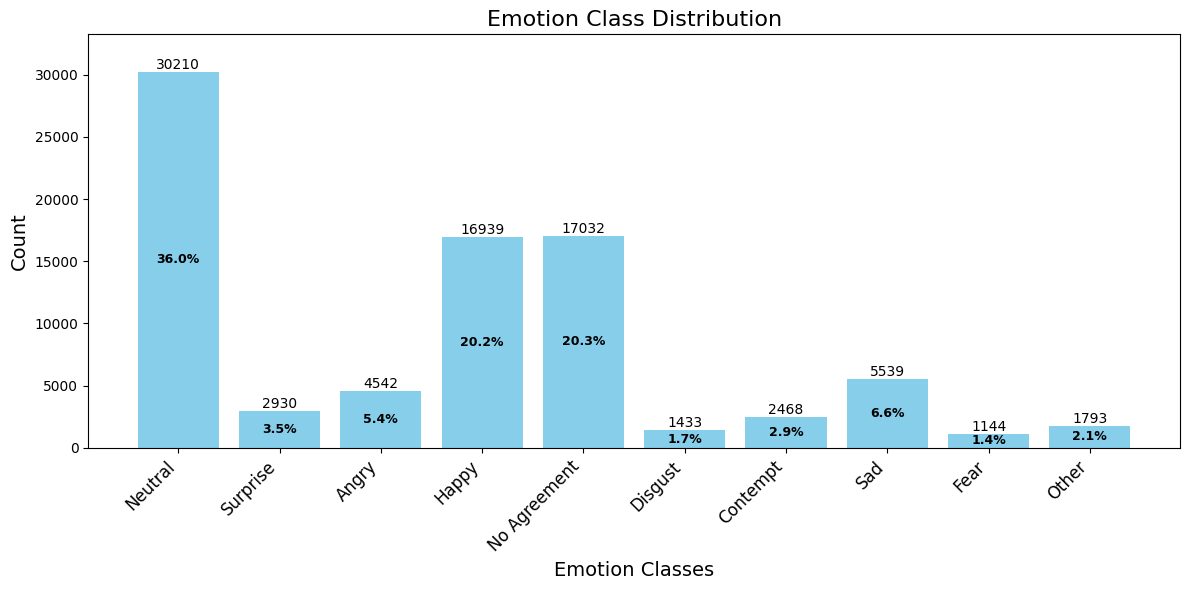

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import os

def plot_emotion_class_distribution_from_file(file_path):
    """
    Read a file containing emotion labels and plot their distribution.
    
    The file should have lines formatted as:
    path/to/audio.wav; LABEL; A:value; V:value; D:value;
    where LABEL is a single character emotion code.
    
    Args:
        file_path (str): Path to the file containing emotion labels
    """
    # Check if file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    # Emotion code mapping
    emotion_mapping = {
        'A': 'Angry',
        'H': 'Happy',
        'S': 'Sad', 
        'F': 'Fear',
        'U': 'Surprise',
        'D': 'Disgust',
        'C': 'Contempt',
        'N': 'Neutral',
        'X': 'No Agreement',
        'O': 'Other'
    }
    
    # Read file and extract emotion labels
    emotion_labels = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            # Skip empty lines
            if not line.strip():
                continue
                
            # Parse line - split by semicolons
            parts = line.strip().split(';')
            
            # Check if line has the expected format
            if len(parts) >= 2:
                # Get emotion label (second part after trimming whitespace)
                label = parts[1].strip()
                emotion_labels.append(label)
    
    # Count occurrences of each emotion label
    counter = Counter(emotion_labels)
    
    # Convert short codes to full emotion names
    emotion_counts = {}
    for label, count in counter.items():
        full_name = emotion_mapping.get(label, label)
        emotion_counts[full_name] = count
    
    # Create figure and axis
    plt.figure(figsize=(12, 6))
    
    # Extract emotion names and counts
    emotions = list(emotion_counts.keys())
    counts = list(emotion_counts.values())
    
    # Create bar plot
    bars = plt.bar(emotions, counts, color='skyblue')
    
    # Add title and labels
    plt.title('Emotion Class Distribution', fontsize=16)
    plt.xlabel('Emotion Classes', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 0.3,
            f'{int(height)}',
            ha='center', 
            va='bottom',
            fontsize=10
        )
    
    # Add total count
    total_count = sum(counts)
    # plt.figtext(0.5, 0.01, f'Total samples: {total_count}', ha='center', fontsize=12)
    
    # Add percentage labels inside bars
    for bar in bars:
        height = bar.get_height()
        percentage = (height / total_count) * 100
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height/2,
            f'{percentage:.1f}%',
            ha='center', 
            va='center',
            fontsize=9,
            color='black',
            fontweight='bold'
        )
    
    # Customize y-axis based on data
    plt.ylim(0, max(counts) * 1.1)  # Add some space for the labels
    
    # Improve layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    # Return the count data and figure for further processing if needed
    return emotion_counts, plt.gcf()

# Example usage:
emotion_counts, fig = plot_emotion_class_distribution_from_file('/proj/speech/users/syk2145/nrse/labels/msp1_11-train-clean.txt')
# fig.savefig('emotion_distribution.png', dpi=300, bbox_inches='tight')

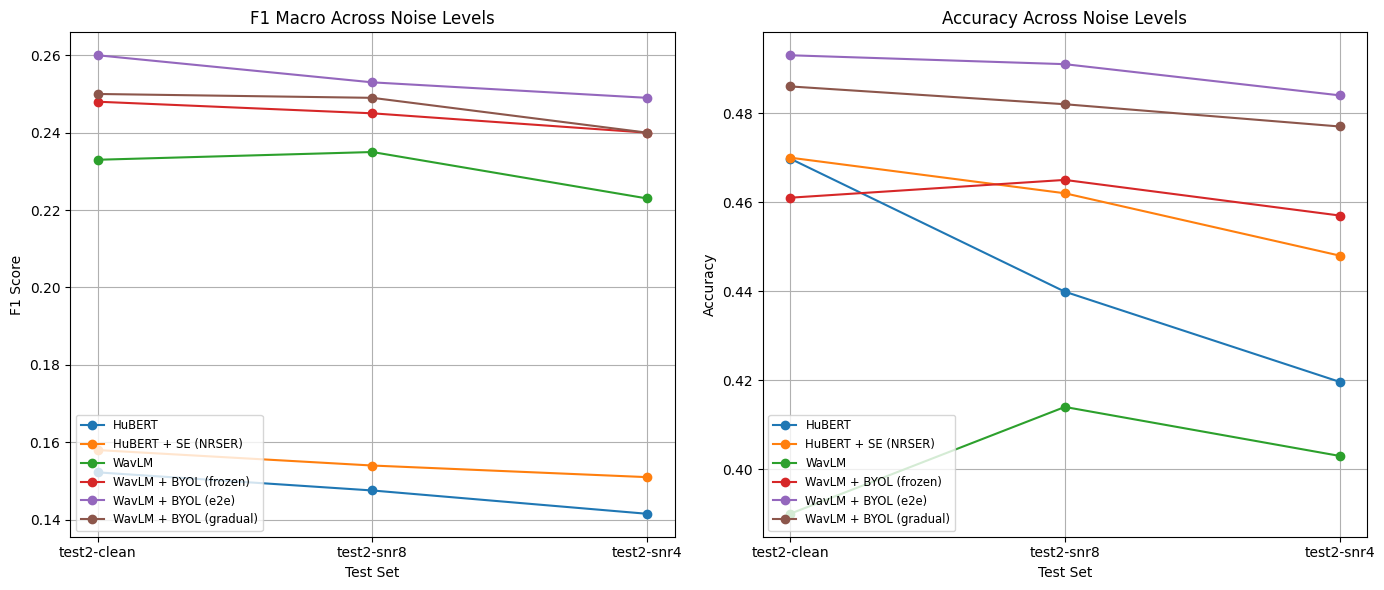

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Updated model list excluding HuBERT (noisy)
models = [
    "HuBERT", "HuBERT + SE (NRSER)",
    "WavLM", "WavLM + BYOL (frozen)", "WavLM + BYOL (e2e)", "WavLM + BYOL (gradual)"
]

# Updated F1 scores
f1_clean = [0.152237, 0.158, 0.233, 0.248, 0.260, 0.250]
f1_snr8 = [0.147555, 0.154, 0.235, 0.245, 0.253, 0.249]
f1_snr4 = [0.14153, 0.151, 0.223, 0.240, 0.249, 0.240]

# Updated Accuracy scores
acc_clean = [0.469794, 0.470, 0.390, 0.461, 0.493, 0.486]
acc_snr8 = [0.439892, 0.462, 0.414, 0.465, 0.491, 0.482]
acc_snr4 = [0.419642, 0.448, 0.403, 0.457, 0.484, 0.477]

snr_labels = ["test2-clean", "test2-snr8", "test2-snr4"]

# Plot
plt.figure(figsize=(14, 6))

# F1 Plot
plt.subplot(1, 2, 1)
for i, model in enumerate(models):
    plt.plot(snr_labels, [f1_clean[i], f1_snr8[i], f1_snr4[i]], marker='o', label=model)
plt.title("F1 Macro Across Noise Levels")
plt.xlabel("Test Set")
plt.ylabel("F1 Score")
plt.legend(fontsize='small', loc='lower left')
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
for i, model in enumerate(models):
    plt.plot(snr_labels, [acc_clean[i], acc_snr8[i], acc_snr4[i]], marker='o', label=model)
plt.title("Accuracy Across Noise Levels")
plt.xlabel("Test Set")
plt.ylabel("Accuracy")
plt.legend(fontsize='small', loc='lower left')
plt.grid(True)

plt.tight_layout()
plt.show()